<div class="alert alert-block alert-info" style="font-size: 25px; text-align: center;">
  <b>Tweet Sentiment Analysis</b>
</div>


<div class="alert alert-block alert-warning" style="font-size: 18px;">
<b>Objective:</b> To Analyse the sentiments of tweets ,whether they are positive,negative or neutral. 
</div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



#Text preprocessing libraries
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#ML Modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

#Metrics libraries
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')


<div class="alert alert-block alert-info" style="font-size: 20px; text-align: center;">
  <b>Exploratory Data Analysis</b>
</div>

In [2]:
#Importing the data 
tweets=pd.read_csv('Twitter_Omicron_data_1_1_1.csv')

In [3]:
tweets.head()

,tweets,likes,time,retweet_count
0,6 big questions about new Omicron-targeting bo...,0,2023-03-09 18:24:06,0
1,I'm confused https://t.co/NyfgdYUYAT,0,2023-03-09 18:23:43,0
2,Long COVID less likely after Omicron than afte...,0,2023-03-09 18:22:43,0
3,The finding don't tally with the high numbers ...,0,2023-03-09 18:21:45,0
4,A conference abstract from the European Congre...,1,2023-03-09 18:21:45,1


In [4]:
tweets.shape

(6998, 4)

In [5]:
tweets.isnull().sum()

tweets           0
likes            0
time             0
retweet_count    0
dtype: int64

In [6]:
tweets.duplicated().sum()

0

<div class="alert alert-block alert-success">
    <ul>
        <li>The dataset contains 4 features with 6998 Records , and all seems independent ,so during feature engineering we have to create the target/dependent feature.</li>
        <li>Even though there are 4 features, our primary focus is on sentiment of the Tweets,so 'tweets' is important for us.  </li>
        <li>No null values as far now.</li>
    </ul>
</div>

<div class="alert alert-block alert-info" style="font-size: 20px; text-align: center;">
  <b>Text Preprocessing</b>
</div>

- As our tweets are in raw format so we have to do some basic text cleaning and preprocessing to make it machine interpretable.
- Some of the basic preprocessing involves , removal of url,html tags,punctuations.
- Then tokenization and stemming.

In [7]:
#Creating a copy of original dataset
df=tweets.copy()

In [8]:
#Converting all tweets to lowercase 
df['tweets'] = df['tweets'].str.lower()

In [9]:
#Function to remove html tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [10]:
df['tweets'] = df['tweets'].apply(remove_html_tags)

In [11]:
#Function to remove URL
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [12]:
df['tweets'] = df['tweets'].apply(remove_url)

In [13]:
#Removal of punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [14]:
df['tweets'] = df['tweets'].apply(remove_punctuation)

In [15]:
#Tokenizing the tweets before performing stemming
df['tweets'] = df['tweets'].apply(lambda tweet: word_tokenize(tweet))

# Function for lemmatization and stemming
def lemmatize_and_stem(tokens):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    return [stemmer.stem(lemmatizer.lemmatize(token, pos='v')) for token in tokens]

# Applying lemmatization and stemming to the 'tweets' column
df['processed_tweets'] = df['tweets'].apply(lemmatize_and_stem)

# Removing stopwords and join back into a string
stop_words = set(stopwords.words('english'))
df['processed_tweets'] = df['processed_tweets'].apply(lambda tokens: ' '.join([token for token in tokens if token not in stop_words]))


In [16]:
#final Cleaned tweets 
df

,tweets,likes,time,retweet_count,processed_tweets
0,"[6, big, questions, about, new, omicrontargeti...",0,2023-03-09 18:24:06,0,6 big question new omicrontarget booster boost...
1,"[im, confused]",0,2023-03-09 18:23:43,0,im confus
2,"[long, covid, less, likely, after, omicron, th...",0,2023-03-09 18:22:43,0,long covid less like omicron origin viru swiss...
3,"[the, finding, dont, tally, with, the, high, n...",0,2023-03-09 18:21:45,0,find dont talli high number see bulletin resea...
4,"[a, conference, abstract, from, the, european,...",1,2023-03-09 18:21:45,1,confer abstract european congress clinic micro...
...,...,...,...,...,...
6993,"[cyclconscience, ballouxfrancois, your, argume...",1,2023-02-27 18:56:31,0,cyclconsci ballouxfrancoi argument flaw mask w...
6994,"[bretweinstein, i, dont, think, it, escaped, t...",0,2023-02-27 18:54:55,0,bretweinstein dont think escap open cell door ...
6995,"[50kgold, do, you, have, to, show, your, face,...",0,2023-02-27 18:53:55,0,50kgold show face id run errand gettin cut chi...
6996,"[noxcato, andrewtanyongyi, tahsci, hsom113, mi...",1,2023-02-27 18:49:59,0,noxcato andrewtanyongyi tahsci hsom113 michael...


<div class="alert alert-block alert-info" style="font-size: 20px; text-align: center;">
  <b>Feature Engineering</b>
</div>

- Since we don't have the sentiment feature ,we'll try to calculate it using sentiment scores.

In [17]:
#Calculating Sentiment Scores
df['sentiment'] = df['processed_tweets'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Categorize sentiment into positive, neutral, and negative
df['sentiment_category'] = df['sentiment'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')


In [18]:
df

,tweets,likes,time,retweet_count,processed_tweets,sentiment,sentiment_category
0,"[6, big, questions, about, new, omicrontargeti...",0,2023-03-09 18:24:06,0,6 big question new omicrontarget booster boost...,0.068182,positive
1,"[im, confused]",0,2023-03-09 18:23:43,0,im confus,0.000000,neutral
2,"[long, covid, less, likely, after, omicron, th...",0,2023-03-09 18:22:43,0,long covid less like omicron origin viru swiss...,-0.108333,negative
3,"[the, finding, dont, tally, with, the, high, n...",0,2023-03-09 18:21:45,0,find dont talli high number see bulletin resea...,0.160000,positive
4,"[a, conference, abstract, from, the, european,...",1,2023-03-09 18:21:45,1,confer abstract european congress clinic micro...,-0.083333,negative
...,...,...,...,...,...,...,...
6993,"[cyclconscience, ballouxfrancois, your, argume...",1,2023-02-27 18:56:31,0,cyclconsci ballouxfrancoi argument flaw mask w...,0.000000,neutral
6994,"[bretweinstein, i, dont, think, it, escaped, t...",0,2023-02-27 18:54:55,0,bretweinstein dont think escap open cell door ...,0.000000,neutral
6995,"[50kgold, do, you, have, to, show, your, face,...",0,2023-02-27 18:53:55,0,50kgold show face id run errand gettin cut chi...,0.000000,neutral
6996,"[noxcato, andrewtanyongyi, tahsci, hsom113, mi...",1,2023-02-27 18:49:59,0,noxcato andrewtanyongyi tahsci hsom113 michael...,-0.025000,negative


In [19]:
#checking distribution of sentiments
sentiment_distribution = df['sentiment_category'].value_counts()
print(sentiment_distribution)

positive    2656
neutral     2632
negative    1710
Name: sentiment_category, dtype: int64


<div class="alert alert-block alert-success">
    <ul>
        <li>Now we have cleaned the tweets and calculated sentiments also, so we can now continue to modelling.</li>
    </ul>
</div>

<div class="alert alert-block alert-info" style="font-size: 20px; text-align: center;">
  <b>Modelling</b>
</div>

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweets'], df['sentiment_category'], test_size=0.2, random_state=42)

- Count Vectorization provides a way to represent text data in a format suitable for machine learning algorithms.
- It converts a collection of text documents into a matrix of token counts, representing the frequency of each word (token) in the documents

In [21]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [22]:


# Defining a dictionary of classifier models
classifier_models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Train and evaluate each model
metrics_dict = {}

for model_name, model in classifier_models.items():
    # Train the model
    model.fit(X_train_vec, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    metrics_dict[model_name] = {'Accuracy': accuracy}

# Display the classification reports for all models 
for model_name, metrics in metrics_dict.items():
    print(f"\nClassification Report for {model_name}:\n", classification_report(y_test, y_pred))

# Display the metrics for all models 
for model_name, metrics in metrics_dict.items():
    print(f"\nFor {model_name}:\n", metrics)



Classification Report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

    negative       0.84      0.59      0.69       356
     neutral       0.76      0.92      0.83       527
    positive       0.79      0.78      0.78       517

    accuracy                           0.78      1400
   macro avg       0.80      0.76      0.77      1400
weighted avg       0.79      0.78      0.78      1400


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

    negative       0.84      0.59      0.69       356
     neutral       0.76      0.92      0.83       527
    positive       0.79      0.78      0.78       517

    accuracy                           0.78      1400
   macro avg       0.80      0.76      0.77      1400
weighted avg       0.79      0.78      0.78      1400


Classification Report for Random Forest:
               precision    recall  f1-score   support

    negative       0.84      0.59     

In [23]:
# Encoding the categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment_category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweets'], y_encoded, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Use scikit-learn wrapper for XGBoost
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_encoded)))

# Train the classifier
xgb_classifier.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_vec)

# Decode numeric predictions back to original labels
y_pred_original = label_encoder.inverse_transform(y_pred)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report with original labels
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.83      0.88       356
     neutral       0.89      0.99      0.93       527
    positive       0.93      0.90      0.92       517

    accuracy                           0.91      1400
   macro avg       0.92      0.90      0.91      1400
weighted avg       0.92      0.91      0.91      1400



In [24]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9142857142857143

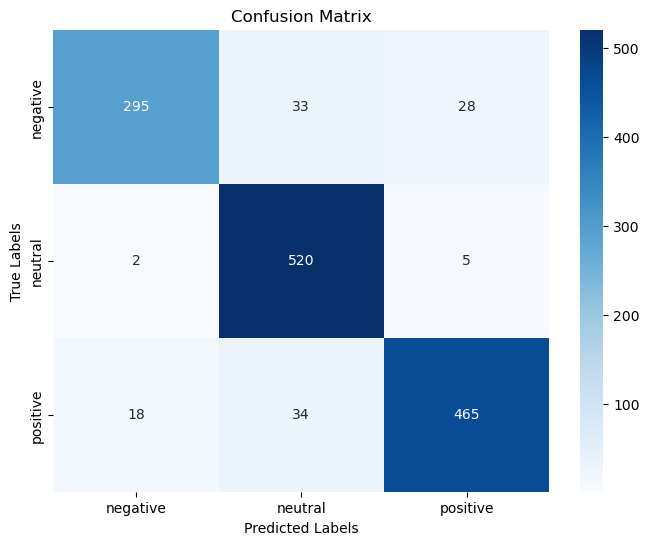

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Decode labels for display
class_labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<div class="alert alert-block alert-info" style="font-size: 20px; text-align: center;">
  <b>Conclusion</b>
</div>

<div class="alert alert-block alert-success">
    <ul>
        <li>Among all models, XGBoost is giving the best accuracy of 91%</li>
        <li>For improvement in model performance, we can apply some more text preprocessing techniques, other than the basic ones we applied</li>
      
        <li>We can experiment with different ways of representing text data using different vectorization techniques such as TF-IDF, word embeddings (Word2Vec, GloVe), or even more advanced methods like BERT embeddings</li>
        <li>We can conduct hyperparameter tuning to find the optimal combination of parameters for the model. This may involve adjusting learning rates, dropout rates, batch sizes, and other hyperparameters</li>
    </ul>
</div>
